In [1]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


# Cardiac Hemodynamics Assessment

In this tutorial, we demonstrate how to use low-cost, non-invasive modalities—**Chest X-ray (CXR)** and **12-lead Electrocardiogram (ECG)**—to assess **Pulmonary Arterial Wedge Pressure (PAWP)**, a key indicator of cardiac hemodynamics. The goal is to reduce reliance on high-cost or invasive methods such as **Cardiac MRI** and **Right Heart Catheterization (RHC)**, enabling early screening of **pulmonary hypertension (PH)** and **heart failure (HF)**.

This notebook is based on the work of **Suvon et al. (MICCAI 2024)**, which introduced a tri-stream pre-training method using a **multimodal variational autoencoder (VAE)** to learn both modality-shared and modality-specific representations. The resulting model, **CardioVAE**, is implemented in the [PyKale](https://github.com/pykale/pykale) library. Here, we provide a concise example of how to pre-train and fine-tune this model.

---

### **Objectives**

1. **Load** a preprocessed subset of 50K paired multimodal dataset from **MIMIC-CXR** and **MIMIC-IV-ECG**. Due to resource constraints in Colab, we use a reduced version of the dataset. The full preprocessing pipeline is also shared for reference.

2. **Pre-train** the CardioVAE model using a small subset of the paired data. This step illustrates how to run the tri-stream pretraining pipeline and save the resulting model.

3. **Load** a separate, labeled subset of paired CXR+ECG data for fine-tuning. Labels represent **healthy** versus **cardiothoracic abnormality** cases.

4. **Fine-tune** the pre-trained CardioVAE model on the labeled subset to adapt it for a downstream classification task.

5. **Interpret** the fine-tuned model using **Integrated Gradients** from the Captum library to identify and visualize modality-specific salient features.

**Note:** Please make a shortcut of https://drive.google.com/drive/folders/1N7-fMWsdK-tuB76SdC-GF1njYYGx0Z-i?usp=sharing in you MyDrive.

# Setup

As a starting point, we will install the required packages and load a set of helper functions to support the tutorial workflow. To keep the output clean and focused on interpretation, we also suppress unnecessary warnings.

Several helper scripts are included to modularize the code and simplify the workflow. These can be inspected directly as `.py` files in the notebook’s working directory:

- **`pretraining_config.py`**: Defines the base configuration settings for pretraining **CardioVAE**, which can be customized or overridden using external `.yml` files.

- **`finetune_config.py`**: Defines the base configuration settings for the fine-tuning stage. These can also be overridden with `.yml` configuration files.

- **`remap_model_parameters.py`**: The original CardioVAE model (MICCAI 2024) used a different naming convention for model parameters. Since the model has now been integrated into the **PyKale** library with a unified API, this script remaps the original pre-trained model weights to the new parameter names for compatibility.


In [2]:
import os
import site
import sys
import warnings
import logging

warnings.filterwarnings("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

# Suppress almost all PyTorch Lightning INFO logs
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)
logging.getLogger("pytorch_lightning.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("pytorch_lightning.accelerators.cuda").setLevel(logging.WARNING)

# Allow INFO logs for model summary only
logging.getLogger("pytorch_lightning.callbacks.model_summary").setLevel(logging.INFO)

if "google.colab" in str(get_ipython()):
    sys.path.insert(0, site.getusersitepackages())
    !git clone --single-branch --branch heart-tutorial https://github.com/pykale/embc-mmai25.git
    %cp -r /content/embc-mmai25/tutorials/cardiac-hemodynamics-assesment/* /content/
    %rm -r /content/embc-mmai25

Cloning into 'embc-mmai25'...
remote: Enumerating objects: 142, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 142 (delta 9), reused 15 (delta 6), pack-reused 107 (from 1)
Receiving objects: 100% (142/142), 556.72 KiB | 8.98 MiB/s, done.
Resolving deltas: 100% (47/47), done.
cp: cannot stat '/content/embc-mmai25/tutorials/cardiac-hemodynamics-assesment/*': No such file or directory


## Packages

The main packages required for this tutorial are:

- **pykale**: An open-source machine learning library developed at the University of Sheffield, focused on biomedical and scientific applications. It supports multimodal learning, domain adaptation, and interpretability.

- **wfdb**: A toolkit for reading, writing, and processing physiological signal data, especially useful for ECG waveform analysis.

- **yacs**: A lightweight configuration management library that helps organize experimental settings in a structured, readable format.

- **pytorch-lightning**: A high-level framework built on PyTorch that simplifies training workflows, making code cleaner and easier to scale.

- **tabulate**: Used to print tabular data in a readable format, helpful for summarizing results or configuration parameters.

- **captum**: A model interpretability library for PyTorch, providing tools such as Integrated Gradients to explain model predictions.

- **neurokit2**: A user-friendly library for physiological signal processing, especially for extracting and analyzing ECG features.

---

### Additional Notes for Colab

Some non-critical dependencies (e.g., `torch-geometric`) may face version conflicts when installing `pykale` on Colab. These are handled manually in the installation step.  
**Note:** If you're running this notebook for the first time in Colab, be sure to **restart the runtime after installation** to properly load all libraries.


In [3]:
!pip uninstall --quiet -y torch torchvision torchaudio torchdata

!pip install --quiet torch==2.3.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.3.0+cu121.html

!pip install --quiet --user \
    git+https://github.com/pykale/pykale@main \
    yacs==0.1.8 wfdb pytorch-lightning tabulate captum neurokit2\
    && echo "pykale,yacs and wfdb installed successfully ✅" \
    || echo "Failed to install pykale,yacs and wfdb ❌"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.0/781.0 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 99.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 93.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 109.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Pre-training Configuration

To reduce code clutter in the notebook, we use a dedicated configuration file—`pretraining_config.py`—which defines the default parameters for pre-training **CardioVAE**. These defaults can be easily customized by providing an external `.yml` configuration file, such as `experiments/pretraining_base.yml`.

This setup enables clear separation between code and experiment settings, making the workflow more modular and reproducible.

Refer to the provided configuration files for detailed customization instructions.  
A breakdown of each configurable option is described in the sections that follow.


In [1]:
from pretraining_config import get_cfg_defaults

cfg = get_cfg_defaults()
cfg.merge_from_file("pretraining_base.yml")
print(cfg)

# laoding

DATA:
  BATCH_SIZE: 32
  CXR_PATH: /content/drive/MyDrive/EMBC_workshop_data/cxr_features_tensor_1000.pt
  ECG_PATH: /content/drive/MyDrive/EMBC_workshop_data/ecg_features_tensor_1000.pt
  NUM_WORKERS: 2
MODEL:
  INPUT_DIM_CXR: 1
  INPUT_DIM_ECG: 60000
  LATENT_DIM: 128
  NUM_LEADS: 12
TRAIN:
  ACCELERATOR: gpu
  DATA_DEVICE: cpu
  DEVICE: cuda
  DEVICES: 1
  EPOCHS: 10
  LAMBDA_IMAGE: 1.0
  LAMBDA_SIGNAL: 10.0
  LR: 0.001
  SAVE_PATH: cardioVAE.pth
  SCALE_FACTOR: 0.0001
  SEED: 123


# Data Loading and Preprocessing

Both image and signal data typically require common preprocessing steps such as resizing, normalization, tensor conversion, and interpolation before being fed into a deep learning model.

In this tutorial, we use a **preprocessed subset (first 1000 samples)** of the paired CXR and ECG data to demonstrate the pretraining process. This helps reduce complexity and avoids the time-intensive process of loading and preprocessing the full dataset.

However, we also provide the CSV files containing subject IDs for the entire 50K paired dataset. If you wish to pre-train the model on the full data, you can use the **PyKale API** to load samples directly from the CXR and ECG directories with preprocessing included.

To keep this tutorial lightweight and runnable in environments like **Google Colab**, the full-data loading functionality is commented out by default but can be easily enabled.

---

**Note:**  
Please ensure the shared folder **`EMBC_workshop_data`** is added as a **shortcut to your Google Drive (My Drive)** to access the required files.


In [ ]:
# (OPTIONAL)
# from kale.loaddata.signal_access import load_ecg_from_folder
# from kale.loaddata.image_access import load_images_from_dir

# ecg_tensor = load_ecg_from_folder("/data/ecg/", "ecg_files.csv")
# cxr_tensor = load_images_from_dir("/data/cxr/", "cxr_files.csv")

In [2]:
import torch
from kale.loaddata.signal_image_access import SignalImageDataset
from kale.utils.seed import set_seed
import random
import numpy as np
import torch

set_seed(cfg.TRAIN.SEED)

ecg_tensor = torch.load(cfg.DATA.ECG_PATH, map_location=cfg.TRAIN.DATA_DEVICE)
cxr_tensor = torch.load(cfg.DATA.CXR_PATH, map_location=cfg.TRAIN.DATA_DEVICE)
print("ECG tensor shape:", ecg_tensor.shape)
print("CXR tensor shape:", cxr_tensor.shape)
# Prepare train and val datasets using your provided method
train_dataset, val_dataset = SignalImageDataset.prepare_data_loaders(
    ecg_tensor, cxr_tensor
)

ECG tensor shape: torch.Size([1000, 1, 60000])
CXR tensor shape: torch.Size([1000, 1, 224, 224])


# Multimodal pretraining

## Multimodal Variational Autoencoder Pretraining

We implement a **multimodal variational autoencoder (VAE)** using **PyKale** and **PyTorch Lightning** to jointly learn representations from paired **Chest X-ray (CXR)** images and **ECG** signals.  
This framework enables **unsupervised pretraining** that captures the underlying relationships between these two clinically relevant modalities.

---

### Key Steps

#### 🔧 Model Architecture
We instantiate the `SignalImageVAE`, which contains **parallel encoders and decoders** for each modality. These are fused into a **shared latent space**, allowing the model to learn both modality-specific and modality-shared representations.

#### ⚙️ Trainer Setup
We use the `SignalImageTriStreamVAETrainer` to manage the **multistream training process**, handling:

- Joint and individual modality reconstructions  
- ELBO loss computation  
- Logging and evaluation

All hyperparameters—including learning rate, batch size, latent dimension, and modality-specific loss weights—are defined in a **central configuration file** to ensure full reproducibility.

#### 🚀 Training Execution
The training loop is executed using **PyTorch Lightning’s `Trainer`**, which manages:

- Automatic GPU/CPU selection  
- Epoch scheduling  
- Checkpointing and logging  

Model weights are saved after training for later **fine-tuning** or **evaluation**.

#### 📁 Configuration
All major parameters (data paths, batch size, learning rate, number of epochs, etc.) are defined in a **YAML or Python config**.  
This enables reproducible and modifiable experimentation, especially useful for scaling to larger datasets or different tasks.

---

> **Note:**  
> To run this tutorial successfully on **Google Colab** without GPU or memory errors, some hyperparameters were adjusted:  
> - `latent_dim` was reduced from **256** to **128**  
> - `max_epochs` was set to **10** for quick training  
>   
> For better performance and stable representations, we recommend training for **at least 100 epochs** with a latent dimension of **256** in a full-scale environment.


In [ ]:
import pytorch_lightning as pl
from kale.pipeline.multimodal_trainer import SignalImageTriStreamVAETrainer
from kale.embed.multimodal_encoder import SignalImageVAE

model = SignalImageVAE(
    image_input_channels=cfg.MODEL.INPUT_DIM_CXR,
    signal_input_dim=cfg.MODEL.INPUT_DIM_ECG,
    latent_dim=cfg.MODEL.LATENT_DIM,
)

# PyKale trainer instance (all from config)
pl_trainer = SignalImageTriStreamVAETrainer(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    batch_size=cfg.DATA.BATCH_SIZE,
    num_workers=cfg.DATA.NUM_WORKERS,
    lambda_image=cfg.TRAIN.LAMBDA_IMAGE,
    lambda_signal=cfg.TRAIN.LAMBDA_SIGNAL,
    lr=cfg.TRAIN.LR,
    annealing_epochs=cfg.TRAIN.EPOCHS,
    scale_factor=cfg.TRAIN.SCALE_FACTOR,
)

trainer = pl.Trainer(
    max_epochs=cfg.TRAIN.EPOCHS,
    accelerator=cfg.TRAIN.ACCELERATOR,
    devices=cfg.TRAIN.DEVICES,
    log_every_n_steps=10,
)

trainer.fit(pl_trainer)

# Save model state dict
torch.save(model.state_dict(), cfg.TRAIN.SAVE_PATH)
print(f"Saved model state dictionary to '{cfg.TRAIN.SAVE_PATH}'")

INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type           | Params | Mode 
-------------------------------------------------
0 | model | SignalImageVAE | 204 M  | train
-------------------------------------------------
204 M     Trainable params
0         Non-trainable params
204 M     Total params
816.722   Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

## Finetuning Configuration

To keep the notebook clean and modular, we use a dedicated configuration file—`finetune_config.py`—that defines the default parameters for fine-tuning **CardioVAE**.  
These defaults can be customized using an external `.yml` file, such as `experiments/finetune_base.yml`.

This setup ensures reproducibility and flexibility across different downstream tasks and datasets.

Please refer to the provided configuration files for detailed instructions on how to adjust parameters such as learning rate, number of epochs, loss weights, and model paths.

A breakdown of each configurable option is provided in the following sections.


In [1]:
from finetune_config import get_cfg_defaults

cfg = get_cfg_defaults()
cfg.merge_from_file("finetune_base.yml")
print(cfg)

DATA:
  BATCH_SIZE: 32
  CSV_PATH: /content/drive/MyDrive/EMBC_workshop_data/chexpert_healthy_abnormality_subset.csv
  CXR_PATH: /content/drive/MyDrive/EMBC_workshop_data/cxr_features_tensor_last_1000.pt
  DATA_DEVICE: cpu
  ECG_PATH: /content/drive/MyDrive/EMBC_workshop_data/ecg_features_tensor_last_1000.pt
  NUM_WORKERS: 2
FT:
  ACCELERATOR: gpu
  CKPT_PATH: /content/drive/MyDrive/EMBC_workshop_data/CardioVAE.pth
  DEVICE: cuda
  DEVICES: 1
  EPOCHS: 10
  HIDDEN_DIM: 128
  KFOLDS: 5
  LR: 0.001
  NUM_CLASSES: 2
  SEED: 42
INTERPRET:
  CXR_THRESHOLD: 0.7
  ECG_THRESHOLD: 0.7
  LEAD_NUMBER: 12
  SAMPLE_IDX: 101
  SAMPLING_RATE: 500
  ZOOM_RANGE: [3, 3.5]
MODEL:
  INPUT_DIM_ECG: 60000
  INPUT_IMAGE_CHANNELS: 1
  LATENT_DIM: 256
  NUM_LEADS: 12


# Data Loading and Preprocessing

Similar to the pretraining stage, we prepare paired CXR and ECG data for fine-tuning.  
However, unlike the original fine-tuning example in **Suvon et al. (MICCAI 2024)**—which used a private in-house dataset—we use a **publicly available** small subset from **MIMIC-CXR** and **MIMIC-IV-ECG**, with binary labels:

- **Healthy** → `0`  
- **Cardiothoracic Abnormality** → `1`

This subset is carefully selected to ensure it is **not included in the original 50K samples** used during pretraining, thereby simulating a real downstream evaluation scenario.


In [3]:
import torch
import pandas as pd

X_ecg_tensor = torch.load(cfg.DATA.ECG_PATH, map_location=cfg.DATA.DATA_DEVICE)
X_image_tensor = torch.load(cfg.DATA.CXR_PATH, map_location=cfg.DATA.DATA_DEVICE)
df = pd.read_csv(cfg.DATA.CSV_PATH)
labels = torch.tensor(df["label"].values, dtype=torch.long)

# Multimodal Fine-tuning and Evaluation

## Cross-Validation Split

To assess classification performance in a **robust and unbiased** manner, we use a **Stratified K-Fold (SKF)** cross-validation strategy.  
This ensures that each fold maintains the original class distribution (e.g., healthy vs. abnormal), which is especially important in medical datasets where class imbalance is common.

All cross-validation hyperparameters are defined in the config for full reproducibility:

- **`cv_strategy`**: The cross-validation method  
  - *Options*: `"skf"` (Stratified K-Fold)  
  - *Default*: `"skf"`

- **`num_folds`**: Number of folds  
  - *Default*: As defined in config (e.g., `5`)

- **`random_state`**: Seed for reproducibility  
  - *Default*: As defined in config (e.g., `42`)

---

## Model Definition

For downstream classification, we adopt a **transfer learning setup**, where a pretrained **multimodal VAE** is used as a **feature extractor**. A shallow classifier is then fine-tuned to predict binary patient status:

- **Healthy (`0`)**  
- **Cardiothoracic Abnormality (`1`)**

The classifier is implemented as a **PyTorch Lightning module**, where a lightweight classification head is added on top of the frozen or partially trainable encoder.

All model-related hyperparameters are defined in the config for reproducibility:

- **`feature_extractor`**: Pretrained multimodal VAE (`SignalImageVAE`)
- **`classifier_head`**: Single hidden layer or linear layer for binary classification
- **`optimizer`**: Adam optimizer (e.g., learning rate = `0.001`)
- **`epochs`**: Number of fine-tuning epochs (e.g., `15`)
- **`metrics`**: Accuracy and AUROC are reported for each fold

---

## Full Pipeline Overview

The complete fine-tuning pipeline is managed using **PyTorch Lightning**, with cross-validation handled via `sklearn.model_selection.StratifiedKFold`.

For each fold:

1. The pretrained **CardioVAE** model is loaded.
2. A new classification head is initialized.
3. The model is trained and validated on the corresponding train/validation split.

This setup ensures both **reproducibility** and **fair performance evaluation** across all folds.


In [4]:
from tabulate import tabulate
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
import numpy as np
import torch
import pytorch_lightning as pl
from kale.embed.multimodal_encoder import SignalImageVAE
from kale.pipeline.multimodal_trainer import SignalImageFineTuningTrainer
from remap_model_parameters import remap_state_dict_keys

# Cross-validation setup
skf = StratifiedKFold(n_splits=cfg.FT.KFOLDS, shuffle=True, random_state=cfg.FT.SEED)
fold_results = []

for fold, (train_ids, val_ids) in enumerate(skf.split(np.zeros(len(labels)), labels)):
    print(f"--- Fold {fold+1} ---")

    # TensorDataset-based splits (no custom class)
    train_dataset = TensorDataset(
        X_image_tensor[train_ids], X_ecg_tensor[train_ids], labels[train_ids]
    )
    val_dataset = TensorDataset(
        X_image_tensor[val_ids], X_ecg_tensor[val_ids], labels[val_ids]
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=cfg.DATA.BATCH_SIZE,
        shuffle=True,
        num_workers=cfg.DATA.NUM_WORKERS,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=cfg.DATA.BATCH_SIZE,
        shuffle=False,
        num_workers=cfg.DATA.NUM_WORKERS,
    )

    # --- Load and remap checkpoint ---
    checkpoint = torch.load(cfg.FT.CKPT_PATH, map_location=cfg.FT.DEVICE)
    checkpoint = remap_state_dict_keys(checkpoint)

    pretrained_mvae = SignalImageVAE(
        image_input_channels=cfg.MODEL.INPUT_IMAGE_CHANNELS,
        signal_input_dim=cfg.MODEL.INPUT_DIM_ECG,
        latent_dim=cfg.MODEL.LATENT_DIM,
    )
    pretrained_mvae.load_state_dict(checkpoint, strict=False)
    pretrained_mvae.to(cfg.FT.DEVICE)
    pretrained_mvae.eval()

    model_pl = SignalImageFineTuningTrainer(
        pretrained_model=pretrained_mvae,
        num_classes=cfg.FT.NUM_CLASSES,
        lr=cfg.FT.LR,
        hidden_dim=cfg.FT.HIDDEN_DIM,
    )

    trainer = pl.Trainer(
        max_epochs=cfg.FT.EPOCHS,
        accelerator=cfg.FT.ACCELERATOR,
        devices=cfg.FT.DEVICES,
        log_every_n_steps=10,
        enable_checkpointing=False,
        logger=False,
    )

    trainer.fit(model_pl, train_dataloaders=train_loader, val_dataloaders=val_loader)

    # Save last fold's model and validation loader
    if fold == cfg.FT.KFOLDS - 1:
        last_fold_model = model_pl
        last_val_loader = val_loader

    val_metrics = trainer.callback_metrics
    acc = val_metrics["val_acc"].item() if "val_acc" in val_metrics else float("nan")
    auc = (
        val_metrics["val_auroc"].item() if "val_auroc" in val_metrics else float("nan")
    )
    mcc = val_metrics["val_mcc"].item() if "val_mcc" in val_metrics else float("nan")
    fold_results.append((acc, auc, mcc))

accuracies, aucs, mccs = zip(*fold_results)
table_data = [
    ["Accuracy", f"{np.mean(accuracies):.3f} ± {np.std(accuracies):.3f}"],
    ["AUC", f"{np.mean(aucs):.3f} ± {np.std(aucs):.3f}"],
    ["MCC", f"{np.mean(mccs):.3f} ± {np.std(mccs):.3f}"],
]
print(tabulate(table_data, headers=["Metric", "Mean ± STD"], tablefmt="fancy_grid"))

--- Fold 1 ---


INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type                            | Params | Mode 
-------------------------------------------------------------------------
0 | model        | SignalImageFineTuningClassifier | 271 M  | train
1 | val_accuracy | BinaryAccuracy                  | 0      | train
2 | val_auc      | BinaryAUROC                     | 0      | train
3 | val_mcc      | BinaryMatthewsCorrCoef          | 0      | train
-------------------------------------------------------------------------
65.9 K    Trainable params
271 M     Non-trainable params
271 M     Total params
1,086.193 Total estimated model params size (MB)
9         Modules in train mode
16        Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

--- Fold 2 ---


INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type                            | Params | Mode 
-------------------------------------------------------------------------
0 | model        | SignalImageFineTuningClassifier | 271 M  | train
1 | val_accuracy | BinaryAccuracy                  | 0      | train
2 | val_auc      | BinaryAUROC                     | 0      | train
3 | val_mcc      | BinaryMatthewsCorrCoef          | 0      | train
-------------------------------------------------------------------------
65.9 K    Trainable params
271 M     Non-trainable params
271 M     Total params
1,086.193 Total estimated model params size (MB)
9         Modules in train mode
16        Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

--- Fold 3 ---


INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type                            | Params | Mode 
-------------------------------------------------------------------------
0 | model        | SignalImageFineTuningClassifier | 271 M  | train
1 | val_accuracy | BinaryAccuracy                  | 0      | train
2 | val_auc      | BinaryAUROC                     | 0      | train
3 | val_mcc      | BinaryMatthewsCorrCoef          | 0      | train
-------------------------------------------------------------------------
65.9 K    Trainable params
271 M     Non-trainable params
271 M     Total params
1,086.193 Total estimated model params size (MB)
9         Modules in train mode
16        Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

--- Fold 4 ---


INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type                            | Params | Mode 
-------------------------------------------------------------------------
0 | model        | SignalImageFineTuningClassifier | 271 M  | train
1 | val_accuracy | BinaryAccuracy                  | 0      | train
2 | val_auc      | BinaryAUROC                     | 0      | train
3 | val_mcc      | BinaryMatthewsCorrCoef          | 0      | train
-------------------------------------------------------------------------
65.9 K    Trainable params
271 M     Non-trainable params
271 M     Total params
1,086.193 Total estimated model params size (MB)
9         Modules in train mode
16        Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

--- Fold 5 ---


INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type                            | Params | Mode 
-------------------------------------------------------------------------
0 | model        | SignalImageFineTuningClassifier | 271 M  | train
1 | val_accuracy | BinaryAccuracy                  | 0      | train
2 | val_auc      | BinaryAUROC                     | 0      | train
3 | val_mcc      | BinaryMatthewsCorrCoef          | 0      | train
-------------------------------------------------------------------------
65.9 K    Trainable params
271 M     Non-trainable params
271 M     Total params
1,086.193 Total estimated model params size (MB)
9         Modules in train mode
16        Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

╒══════════╤═══════════════╕
│ Metric   │ Mean ± STD    │
╞══════════╪═══════════════╡
│ Accuracy │ 0.710 ± 0.035 │
├──────────┼───────────────┤
│ AUC      │ 0.765 ± 0.020 │
├──────────┼───────────────┤
│ MCC      │ 0.417 ± 0.070 │
╘══════════╧═══════════════╛


## Model Interpretability: Visualizing ECG Attribution with Integrated Gradients

To understand which parts of the ECG signal influenced the model's decision, we use **Integrated Gradients**, a gradient-based attribution method provided by the **Captum** library.  
This helps identify salient regions of the ECG that contributed most to the predicted label, improving model transparency and clinical trust.

---

### Step-by-Step Explanation

1. **Data Preparation**  
   We first load a sample from the validation set and separate its CXR and ECG components. The ECG signal is smoothed using **NeuroKit2's `ecg_clean`** function to reduce noise and enhance waveform clarity.

2. **Model Prediction**  
   The sample is passed through the fine-tuned model to generate predicted probabilities and the final label. The model is set to evaluation mode and moved to the appropriate device (`CPU` or `GPU`).

3. **Attribution with Integrated Gradients**  
   Using Captum's `IntegratedGradients`, we compute attribution scores for both the CXR and ECG inputs.  
   Here, we focus on the ECG modality by extracting its corresponding attribution tensor.

4. **Attribution Normalization**  
   The ECG attribution values are normalized between 0 and 1 to prepare for visualization. A fixed threshold (e.g., 0.70) is applied to highlight the most influential regions.

5. **Visualization**  
   We generate two plots:
   - **Full ECG View**: Highlights the important regions across the entire signal (first 12 seconds).
   - **Zoomed-In Segment**: Focuses on a shorter interval (e.g., 3-second segment) with higher-resolution detail of salient points.

   In both plots, red-highlighted regions correspond to time intervals with attribution values above the defined threshold, indicating strong influence on the model’s prediction.

---

### Notes

- The input ECG is assumed to be flattened from a 12-lead concatenated signal (e.g., 5000 samples per lead × 12 leads = 60,000 total points).
- Time is converted into seconds and plotted on the x-axis with respect to lead concatenation.
- This visualization is useful for both **clinical insight** and **debugging model behavior**.



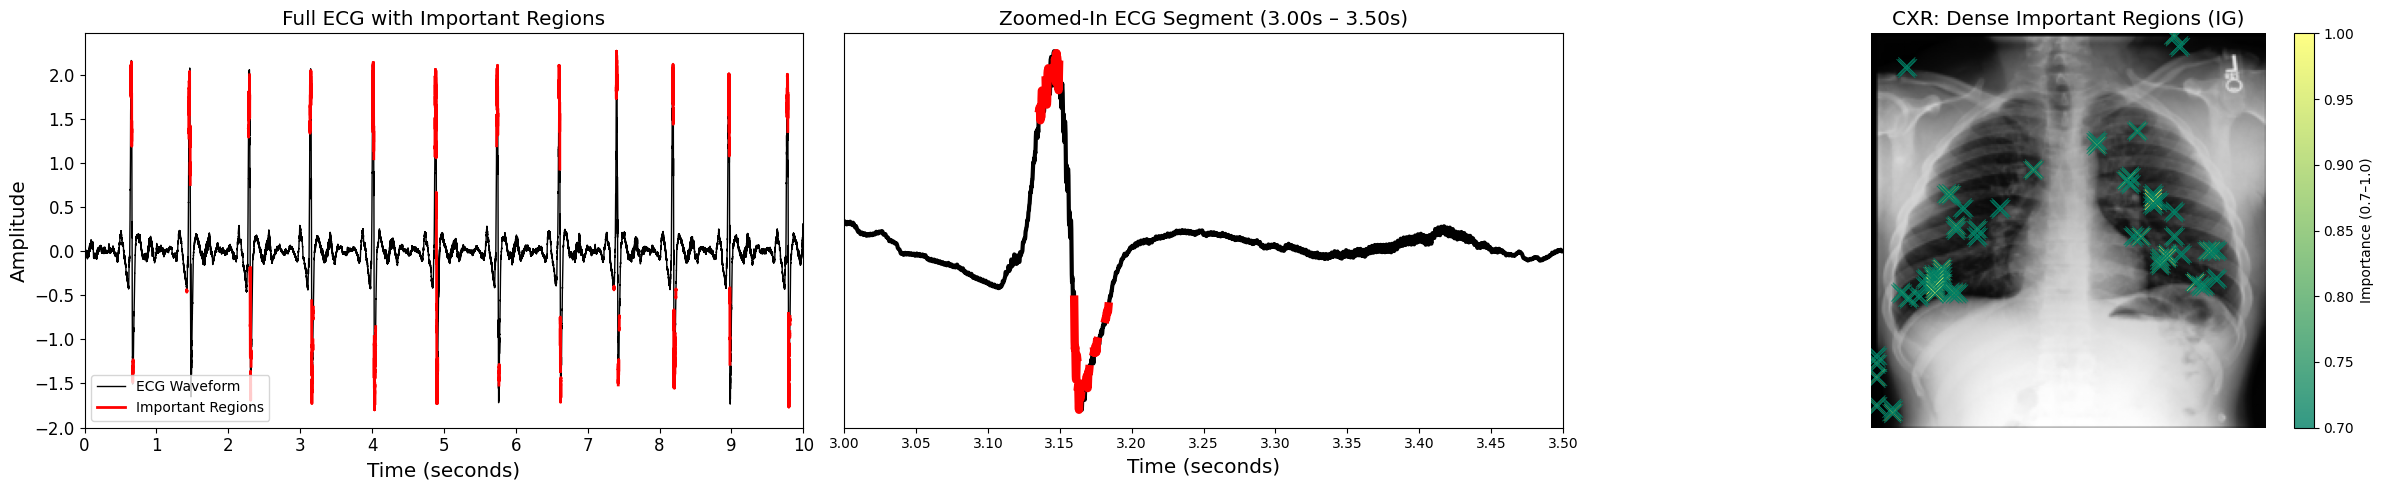

In [76]:
from interpret import multimodal_ecg_cxr_attribution
import matplotlib.pyplot as plt
import numpy as np

# Example usage (set your variables)
cfg = get_cfg_defaults()
# If you load from YAML, use your loader method here instead

sample_idx = cfg.INTERPRET.SAMPLE_IDX
zoom_range = tuple(cfg.INTERPRET.ZOOM_RANGE)
ecg_threshold = cfg.INTERPRET.ECG_THRESHOLD
cxr_threshold = cfg.INTERPRET.CXR_THRESHOLD
lead_number = cfg.INTERPRET.LEAD_NUMBER
sampling_rate = cfg.INTERPRET.SAMPLING_RATE


# Run interpretation
result = multimodal_ecg_cxr_attribution(
    last_fold_model=last_fold_model,
    last_val_loader=last_val_loader,
    sample_idx=sample_idx,
    ecg_threshold=ecg_threshold,
    cxr_threshold=cxr_threshold,
    zoom_range=zoom_range,
)

# --- Plotting (same as before) ---
fig, axes = plt.subplots(1, 3, figsize=(24, 5))
fig.patch.set_facecolor("white")

# 1. Full ECG
axes[0].set_facecolor("white")
axes[0].plot(
    result["full_time"],
    result["ecg_waveform_np"][: result["full_length"]],
    color="black",
    linewidth=1,
    label="ECG Waveform",
)
for idx in result["important_indices_full"]:
    stretch_start = max(0, idx - 6)
    stretch_end = min(result["full_length"], idx + 6 + 1)
    axes[0].plot(
        result["full_time"][stretch_start:stretch_end],
        result["ecg_waveform_np"][stretch_start:stretch_end],
        color="red",
        linewidth=2,
    )
axes[0].set_xlabel("Time (seconds)", fontsize="x-large")
axes[0].set_ylabel("Amplitude", fontsize="x-large")
axes[0].set_title("Full ECG with Important Regions", fontsize="x-large")
axes[0].set_xticks(np.linspace(0, 10, 11))
axes[0].set_xlim([0, 10])
axes[0].tick_params(axis="x", labelsize="large")
axes[0].tick_params(axis="y", labelsize="large")
axes[0].legend(["ECG Waveform", "Important Regions"], fontsize="medium")

# 2. Zoomed ECG
axes[1].set_facecolor("white")
axes[1].plot(
    result["zoom_time"],
    result["segment_ecg_waveform"],
    color="black",
    linewidth=3,
    label="ECG Waveform",
)
for idx in result["important_indices_zoom"]:
    stretch_start = max(0, idx - 6)
    stretch_end = min(len(result["segment_ecg_waveform"]), idx + 6 + 1)
    axes[1].plot(
        result["zoom_time"][stretch_start:stretch_end],
        result["segment_ecg_waveform"][stretch_start:stretch_end],
        color="red",
        linewidth=6,
    )
axes[1].set_xticks(np.linspace(result["zoom_start_sec"], result["zoom_end_sec"], 11))
axes[1].set_xlim([result["zoom_start_sec"], result["zoom_end_sec"]])
axes[1].set_yticks([])
axes[1].set_xlabel("Time (seconds)", fontsize="x-large")
axes[1].set_ylabel("")
axes[1].set_title(
    f'Zoomed-In ECG Segment ({result["zoom_start_sec"]:.2f}s – {result["zoom_end_sec"]:.2f}s)',
    fontsize="x-large",
)

# 3. CXR with points (diamonds)
axes[2].set_facecolor("white")
axes[2].imshow(result["xray_image_np"], cmap="gray", alpha=1)
sc = axes[2].scatter(
    x_pts,
    y_pts,
    c=importance_pts,
    cmap="summer",
    marker="x",
    s=150,
    vmin=cxr_thresh,
    vmax=1.0,
    alpha=0.8,
    linewidths=0.7,
    edgecolor="black",
)
cbar = plt.colorbar(sc, ax=axes[2], fraction=0.04, pad=0.04)
cbar.set_label("Importance (0.7–1.0)")
axes[2].axis("off")
axes[2].set_title("CXR: Dense Important Regions (IG)", fontsize="x-large")

plt.tight_layout()
plt.show()